In [50]:
import numpy as np
import scipy as sp
import scipy.sparse as ss
import seaborn as sns
import matplotlib.pyplot as plt

from par2vec.common import *

### Load Reuters

In [2]:
# Load tokenized reuters
word2id = np.load('data/reuters/reuters_word2id.npy').item(0)
id2word = np.load('data/reuters/reuters_id2word.npy').item(0)
tokenized = list(np.load('data/reuters/reuters_tokenized.npy'))

### Compute document graphs and essentials

In [91]:
# Create graphs for N documents
N=100000
max_w=13

counts = np.zeros((N, max_w))
entropies = []
for i, (A_o, A_i, _, _) in enumerate(get_lapl(tokenized[:N], word2id)):
    if i % 5000 == 0:
        print('{}/{}'.format(i, N))
        
    # Graph
    A = (A_o + A_i).data
    
    # Weight counts
    bincount = np.bincount(A.astype(int))
    for j in range(min(len(bincount), max_w)):
        counts[i, j] = bincount[j]
        
    # Entropies
    entropies.append(sp.stats.entropy((A_o + A_i).data))
    

# Parse data
x = np.arange(1, max_w)
y_mean = np.mean(counts[:,1:], axis=0)
y_std = np.std(counts[:,1:], axis=0)

0/100000
5000/100000
10000/100000
15000/100000
20000/100000


### Plot distribution of non-zero graph weights

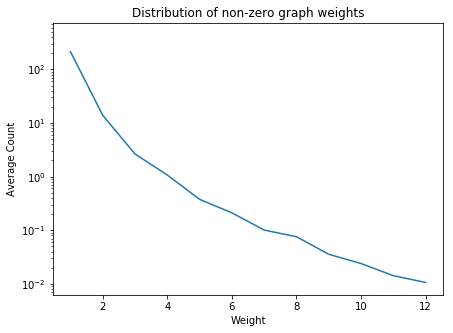

In [75]:
plt.figure(figsize=(7,5))
plt.title('Distribution of non-zero graph weights')
plt.xlabel('Weight')
plt.ylabel('Average Count')
plt.yscale('log')
plt.errorbar(x, y_mean, yerr=y_std)
plt.savefig('plots/dist_nonzero_graph_weights.png')
plt.show()

### Plot distribution graph entropies 

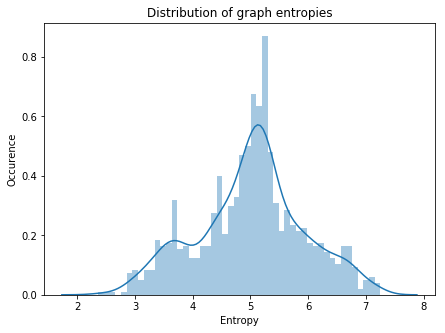

In [89]:
plt.figure(figsize=(7,5))
plt.savefig('plots/dist_graph_entropies.png')
plt.title('Distribution of graph entropies')
plt.xlabel('Entropy')
plt.ylabel('Occurence')
sns.distplot(ents, bins=50)
plt.show()